### Plot results

In [1]:
library(tidyverse)
theme_set(theme_light())
theme_update(text = element_text(family = "Calibri"), strip.text = element_text(colour = 'black'))

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
results_df = read_csv("analysis/spot_detection/seq_qc/rep0/A_PB2/results.csv")

Rows: 16 Columns: 31
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (31): total, correct_to_1, additional_to_1, missing_to_1, additionalAndM...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


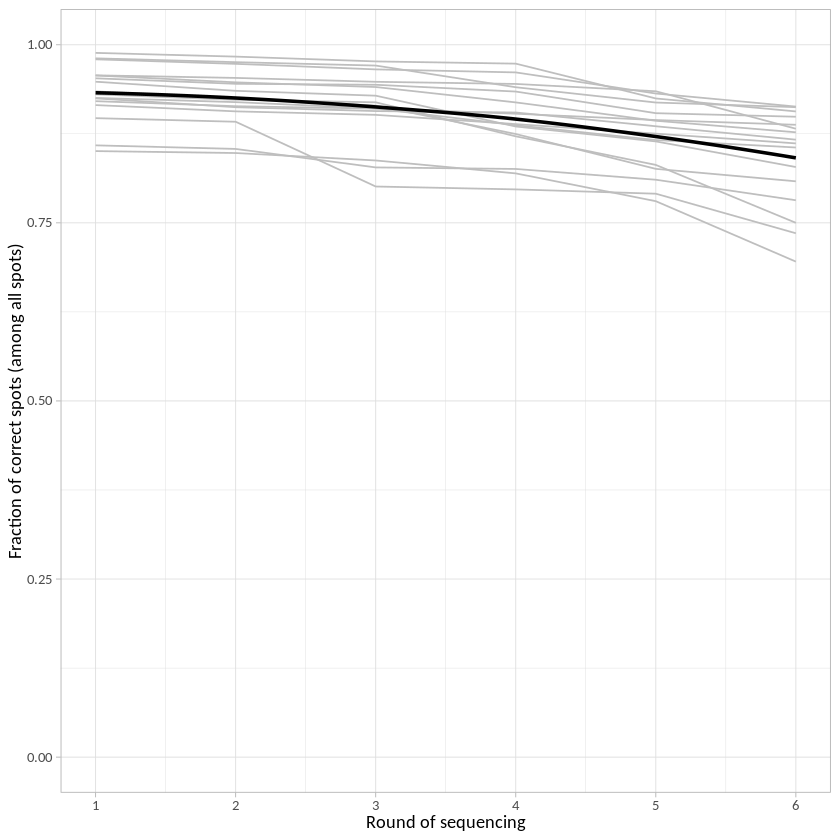

In [3]:
results_df %>%
	pivot_longer(cols=contains("correct_to"), names_to="correct_to", values_to="correct") %>%
	select(fov, total, correct_to, correct) %>%
	mutate(correct_to = parse_number(correct_to), correct=correct/total, fov=as_factor(fov)) %>%
	ggplot(aes(x=correct_to, y=correct, group=fov)) +
		#geom_point() +
		geom_line(color="gray") +
		geom_smooth(aes(group=1),color="black",method="loess",formula=y~x, se=FALSE) +
		xlab("Round of sequencing") +
		ylab("Fraction of correct spots (among all spots)") + 
		scale_x_continuous(breaks=1:6) +
		ylim(0,1) +
		NULL

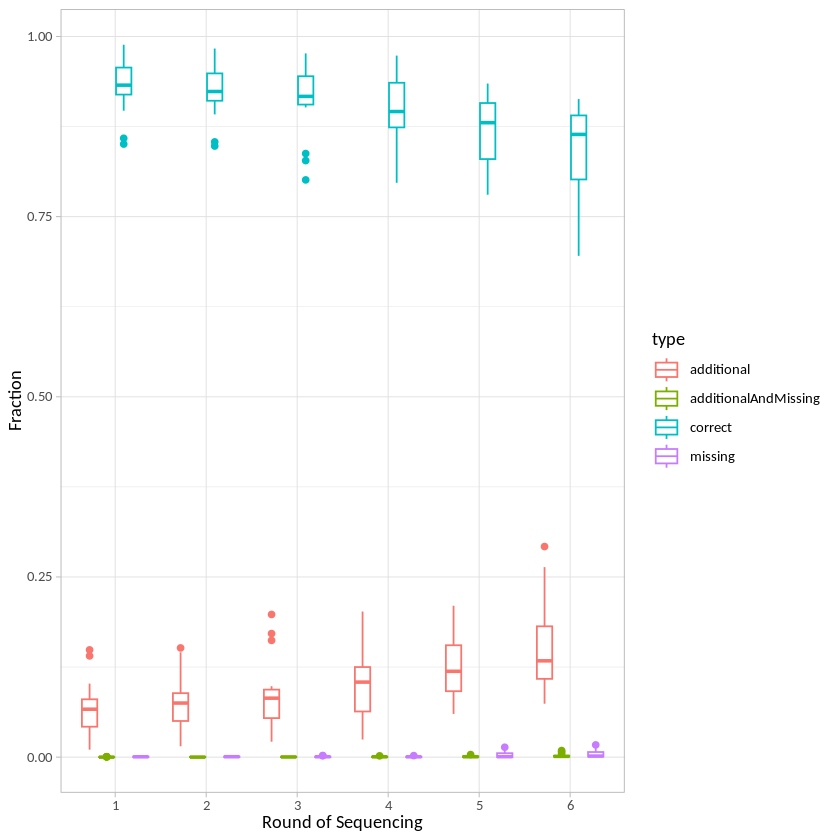

In [4]:
results_df %>%
	pivot_longer(cols=contains("_to_"), names_to="round", values_to="fraction") %>%
	mutate(
		type = str_remove(round, "_to_.*"),
		round = as.factor(parse_number(round)),
		fraction = fraction/total
	) %>%
	select(total, type, round, fraction, fov) %T>%
  write_tsv("figures/supp-fig6c-correct_by_round-detailed-box.tsv") %>%
	ggplot(aes(x=round, y=fraction, color=type)) +
		geom_boxplot() +
    xlab("Round of Sequencing") +
    ylab("Fraction")

In [5]:
ggsave("figures/supp-fig6c-correct_by_round-detailed-box.svg", width = 6, height = 4, dpi = 300)

In [6]:
results_df %>%
	pivot_longer(cols=contains("_to_"), names_to="round", values_to="fraction") %>%
	mutate(
		type = str_remove(round, "_to_.*"),
		round = as.factor(parse_number(round)),
    matching = fraction,
		fraction = fraction/total
	) %>%
	select(total, matching, type, round, fraction, fov) %>%
  filter(type=="correct") %>%
  group_by(round) %>%
  summarize(total=sum(total), matching=sum(matching), median_fraction = median(fraction)) %>%
  mutate(fraction = matching/total) %>%
	identity()

round,total,matching,median_fraction,fraction
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
1,29911,27888,0.9324921,0.9323660
2,29911,27665,0.9236887,0.9249106
3,29911,27374,0.9169177,0.9151817
4,29911,26826,0.8958773,0.8968607
5,29911,26052,0.8804033,0.8709839
6,29911,25188,0.8641386,0.8420982


> In an experimental setting, this is advantageous as it would allow the identification of spots that may contain multiple RNA molecules. In this control setting, we decoded greater than 92% of spots after 2 rounds of sequencing, and 84% spots after 6 rounds of sequencing defining the background of our assay (Supplementary Fig. 6c)

## Correct spots by round

Analysis of correct spots per round of sequencing, only considering spots that are correct up to that round.
Either starting with all spots, or restricted to spots, that were correct in round 1.

In [7]:
correct_to <- results_df %>%
	pivot_longer(cols=contains("correct_to"), names_to="correct_to", values_to="correct") %>%
	select(fov, total, correct_to, correct) %>%
	mutate(correct_to = parse_number(correct_to), correct=correct/total, fov=as_factor(fov)) %>%
	group_by(fov) %>%
	arrange(fov, correct_to) %>%
	mutate(prev_correct = lag(correct, default=1), factor=correct/prev_correct) %>%
	identity

In [8]:
correct_after_1 <- results_df %>%
	mutate(total=correct_to_1) %>%
	pivot_longer(cols=contains("correct_to"), names_to="correct_to", values_to="correct") %>%
	select(fov, total, correct_to, correct) %>%
	mutate(correct_to = parse_number(correct_to), correct=correct/total, fov=as_factor(fov)) %>%
	group_by(fov) %>%
	arrange(fov, correct_to) %>%
	mutate(prev_correct = lag(correct, default=1), factor=correct/prev_correct) %>%
	identity

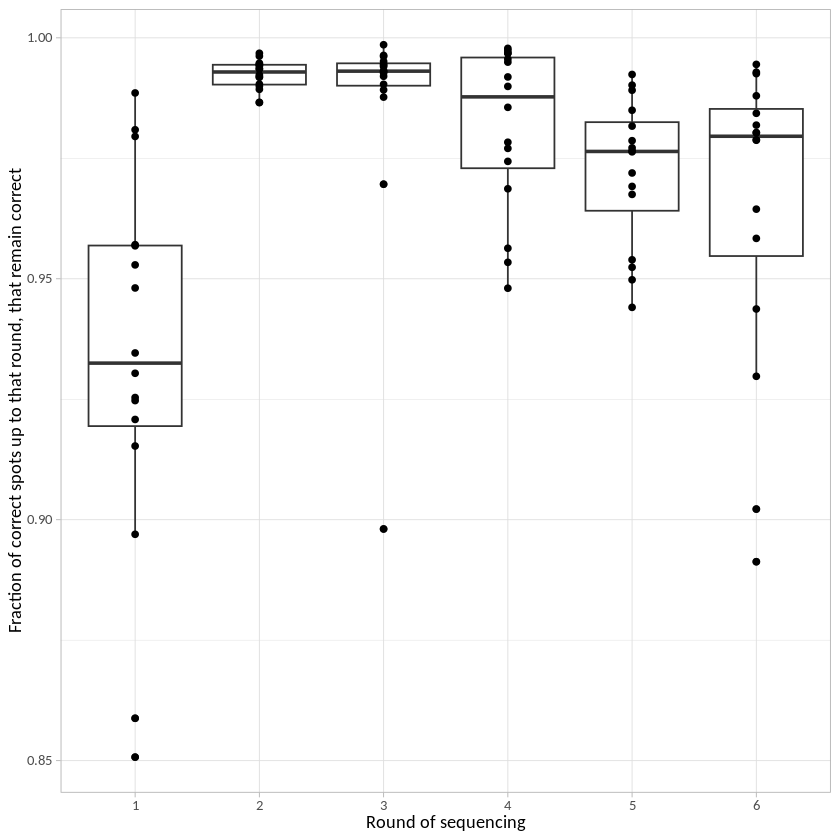

In [9]:
correct_to %>%
	ggplot(aes(y=factor, x=as_factor(correct_to))) +
		geom_boxplot() +
		geom_point() + #aes(color=fov)) +
		xlab("Round of sequencing") +
		ylab("Fraction of correct spots up to that round, that remain correct") +
		# ylim(0,1) +
		NULL

In [10]:
correct_to %>%
	group_by(correct_to) %>%
	#filter(correct_to > 1) %>%
	summarize(median=median(factor)) %>%
  mutate(cumprod(median))

correct_to,median,cumprod(median)
<dbl>,<dbl>,<dbl>
1,0.9324921,0.9324921
2,0.9929100,0.9258808
3,0.9930817,0.9194752
4,0.9877467,0.9082086
5,0.9764206,0.8867936
6,0.9795711,0.8686774


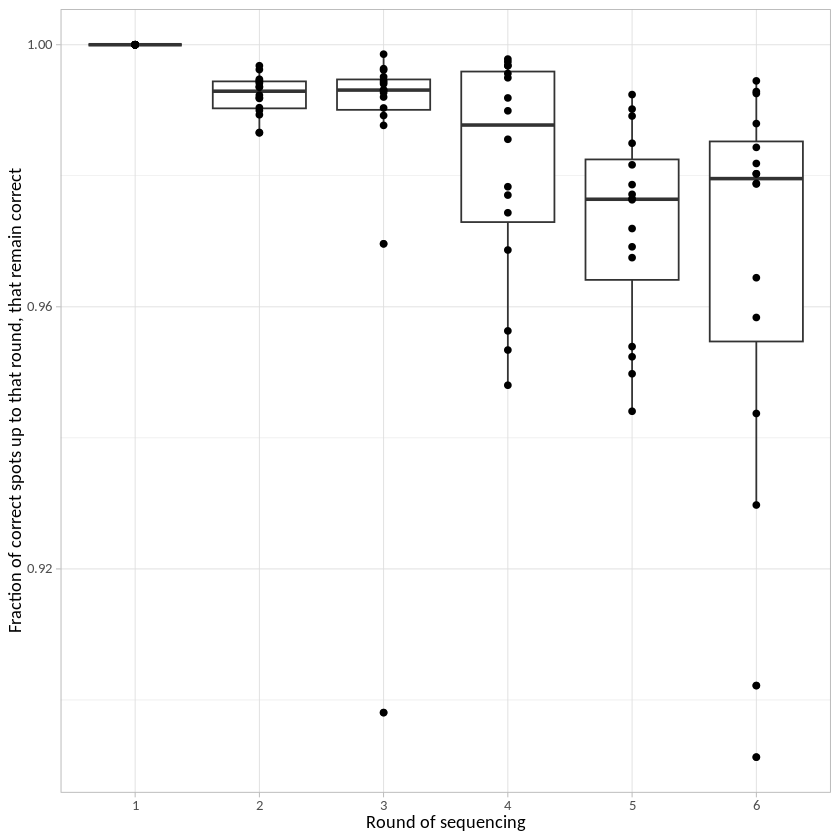

In [11]:
correct_after_1 %>%
	ggplot(aes(y=factor, x=as_factor(correct_to))) +
		geom_boxplot() +
		geom_point() + #aes(color=fov)) +
		xlab("Round of sequencing") +
		ylab("Fraction of correct spots up to that round, that remain correct") +
		#ylim(0,1) +
		NULL

In [12]:
ggsave("figures/supp-fig6b-factor_correct_by_round.svg", width = 6, height = 4, dpi = 300)

In [13]:
correct_to %>%
	ungroup() %>%
	filter(correct_to > 1) %>%
	summarize(median(factor)) %>% pull

[1] 0.9891622

In [14]:
correct_to %>%
	group_by(correct_to) %>%
	filter(correct_to > 1) %>%
	summarize(median=median(factor)) %>%
  mutate(cumprod(median))

correct_to,median,cumprod(median)
<dbl>,<dbl>,<dbl>
2,0.9929100,0.9929100
3,0.9930817,0.9860407
4,0.9877467,0.9739585
5,0.9764206,0.9509931
6,0.9795711,0.9315654


> By following RCP spots that were correctly base-called in the first round of sequencing, we found that nearly 99% of spots were correctly called in the next cycle of sequencing (99.3%, 99.3%, 98.8%, 97.6%, and 98.0% for cycles 2, 3, 4, 5 and 6 respectively)